# Symptom-behaviour analyses - Discovery sample

## Analysis overview

#### Discovery sample

1. Model fitting: [`Model fitting - Discovery.ipynb`](<../../notebooks/discovery/Model fitting - Discovery.ipynb>)
2. Confidence analysis: [`Confidence analysis - Discovery.ipynb`](<../../notebooks/discovery/Confidence analysis - Discovery.ipynb>)
3. Transdiagnostic factor estimation: [`Transdiagnostic factors - Discovery.ipynb`](<../../notebooks/discovery/Transdiagnostic factors - Discovery.ipynb>) 
4. ⭐ **Symptom-behaviour analyses: [`Symptom analyses - Discovery.ipynb`](<../../notebooks/discovery/Symptom analyses - Discovery.ipynb>)** ⭐

#### Replication sample

1. Model fitting: [`Model fitting - Replication.ipynb`](<../../notebooks/replication/Model fitting - Replication.ipynb>)
2. Confidence analysis: [`Confidence analysis - Replication.ipynb`](<../../notebooks/replication/Confidence analysis - Replication.ipynb>)
3. Two-step task analysis: [`Two-step modelling - Replication.ipynb`](<../../notebooks/replication/Two-step modelling - Replication.ipynb>)
4. Transdiagnostic factor estimation: [`Transdiagnostic factors - Replication.ipynb`](<../../notebooks/replication/Transdiagnostic factors - Replication.ipynb>) 
5. Symptom-behaviour analyses: [`Symptom analyses - Replication.ipynb`](<../../notebooks/replication/Symptom analyses - Replication.ipynb>)

#### Test-retest sample

1. Model-fitting: [`Model fitting - Retest.ipynb`](<../../notebooks/retest/Model fitting - Retest.ipynb>)
4. Test-retest reliability analyses: [`Test-retest - Retest.ipynb`](<../../notebooks/retest/Test-retest - Retest.ipynb>) 

#### Follow-up sample

1. Model fitting: [`Model fitting - Follow up.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up.ipynb>) 
3. Test-retest reliability analyses: [`Test-retest - Follow up.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses - Follow up.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up.ipynb>)

#### Follow-up sample (1 year)

1. Model fitting: [`Model fitting - Follow up 1yr.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up 1yr.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up 1yr.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up 1yr.ipynb>)  
3. Test-retest reliability analyses: [`Test-retest - Follow up 1yr.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up 1yr.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses -  Follow up 1yr.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up 1yr.ipynb>)
   
## Notebook overview

This notebook tests for relationships between our behavioural metrics and transdiagnostic symptom dimensions. We also test for relationships between behaviour and state measures of anxiety and depression.


## Imports


In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.linalg import cond
from pingouin import mediation_analysis
from stats_utils.mediation.utils import mediation_analysis_to_markdown_table
from stats_utils.regression.utils import (
    ols_to_markdown_table,
    run_regression_and_plot,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

from transition_uncertainty.analysis_utils import (
    calculate_performance,
    compile_ols_results,
)
from transition_uncertainty.data import load_and_process_data
from transition_uncertainty.style import set_style
from transition_uncertainty.utils import (
    caption_and_save_markdown_tables,
    check_directories,
)

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

set_style("style.mplstyle")

# Create necessary diredtory if it does not exist
if not os.path.exists("results/discovery/symptom_models"):
    os.makedirs("results/discovery/symptom_models")

# Dictionary for renaming variables
variable_rename_dict = {
    "Compul": "CIT",
    "GAD_7": "GAD 7",
    "PHQ_8": "PHQ 8",
    "gender": "Gender",
    "age": "Age",
    "motivation": "Motivation",
    "bet_correct": "Accuracy",
}

/users/user/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Load in data

### 1. Data Loading

The code initially loads multiple datasets related to:

-   **Questionnaire Data:** Participant responses from various questionnaires.
-   **Transdiagnostic Factor Scores:** Predicted factor scores on three transdiagnostic dimensions: Anxiety + Depression (AD), Compulsivity & Intriusive Thought (Compul), and Social Withdrawal (SW)
-   **Model Parameters:** Parameters estimated from computational modelling of behaviour on the task.
-   **Confidence Parameters:** Parameters specifically derived from modelling of confidence reports in the task.

Each dataset is loaded from its respective CSV file using Pandas' `read_csv` function.

### 2. Data Merging

After loading, the datasets are merged sequentially into a single DataFrame named `qdata`. Merging is based on the "subjectID", ensuring all information corresponding to a participant is collated into single rows within the merged DataFrame.

### 3. Data Filtering

Subsequent steps involve filtering the data to exclude particular categories and subjects based on specific conditions:

-   Subjects identifying with gender category "3" ('Other') are excluded due to their small sample size, which may not provide robust estimates in subsequent analyses.
-   Subjects who failed attention checks are excluded.
-   Subjects who incorrectly answered more than one "infrequency item check" are excluded.

### 4. Data Scaling

Post-filtering, variables (excluding 'subjectID' and 'gender') are scaled (standardized) by subtracting their respective means and dividing by their standard deviations.


In [2]:
qdata = load_and_process_data("discovery", scale=True)

Initial number of subjects: 600
Number of included subjects after excluding gender != 0 or 1: 592
Number of included subjects after excluding age < 18 or >= 100: 592
Number of included subjects after excluding attention check failures: 551
Mean (SD) age = 40.75 (12.32)
n male = 275; n female = 276
Number scoring above cutoff for GAD: 116 (21.05%)
Number scoring above cutoff for MDD: 128 (23.23%)
Number of subjects after filtering and processing: 551


/scratch/users/user/transition_uncertainty/transition-learning-public/transition_uncertainty/analysis_utils.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'pink' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  confidence_df.loc[confidence_df["pinkBet"] != 0, "bet_colour"] = "pink"


## Run analyses


### Associations with transdiagnostic factors

Here we run regression models predicting model parameters from symptom dimensions, alongside covariates. We then plot the results.

These models can take a while to run as we use bootstrapping to estimate confidence intervals.

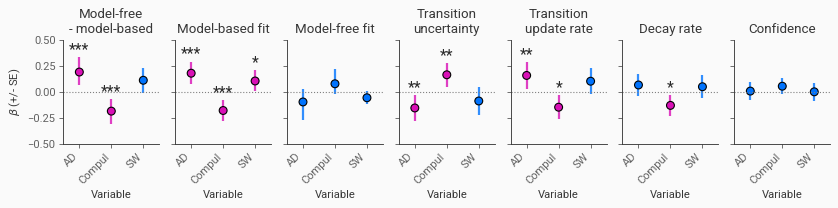

In [3]:
# Create transdiagnostic subdirectory if it does not exist
if not os.path.exists("results/discovery/symptom_models/transdiagnostic"):
    os.makedirs("results/discovery/symptom_models/transdiagnostic")

# Parameters for the models and plots
variables = [
    "MB_MF_WAIC_diff",
    "MB_WAIC",
    "MF_WAIC",
    "transition_var",
    "tau_prob",
    "decay_prob",
    "adjusted_confidence",
]
titles = [
    "Model-free\n- model-based",
    "Model-based fit",
    "Model-free fit",
    "Transition\nuncertainty",
    "Transition\nupdate rate",
    "Decay rate",
    "Confidence",
]

# Add variables and titles to the variable rename dict
variable_rename_dict.update(dict(zip(variables, titles)))

# Create subplots
f, ax = plt.subplots(1, 7, figsize=(10.5, 2.7), sharey=True)

# Common regression formula
formula = "AD + Compul + SW + gender + age + motivation"

# Create an empty list to store model objects
transdiagnostic_models = []

# Create an empty list to store markdown tables
transdiagnostic_markdown_tables = {}

# Number of variables we're correcting for multiple comparisons across This is
# our three main dependent variables (uncertainty, update rate,
# model-basedness) We look at the others here as well, but they are not the
# main focus, and we do not correct for multiple comparisons.
n_variables = 3

# Loop through the variables and corresponding titles, running regression and
# plotting for each
for i, (var, title) in enumerate(zip(variables, titles)):
    # If dependent var is confidence, add performance metrics to formula
    if var == "adjusted_confidence":
        model_formula = formula + " + bet_correct"
    else:
        model_formula = formula

    # Get the number of variables we're correcting across This should be 3 (as
    # specified above) if we're looking at one of our Preregistered dependent
    # variables, as the others don't really matter for these analyses
    n_variables_model = (
        n_variables
        if var in ["transition_var", "tau_prob", "MB_MF_WAIC_diff"]
        else 1
    )

    model, _ = run_regression_and_plot(
        qdata,
        var,
        model_formula,
        20000,
        save_fig=False,
        show_summary=False,
        ax=ax[i],
        forest_plot_kwargs={
            "exclude_param_names": [
                "age",
                "gender",
                "motivation",
                "bet_correct",
            ],
            "significance_thresholds": {
                0.001 / n_variables_model: "***",
                0.01 / n_variables_model: "**",
                0.05 / n_variables_model: "*",
            },
            "alpha": 0.05 / n_variables_model,
        },
    )

    transdiagnostic_models.append(model)  # Store the model object

    # Store the table in markdown form
    transdiagnostic_markdown_tables[title] = ols_to_markdown_table(
        model,
        alpha_corr=0.05 / n_variables_model if n_variables_model > 1 else None,
        predictor_rename_dict=variable_rename_dict,
    )

    # Set title for each subplot
    ax[i].set_title(title)

# Adjust y-axis limits.
ax[0].set_ylim(-0.5, 0.5)

# Remove y label from plots 1-4
for i in range(1, 7):
    ax[i].set_ylabel("")

# Tighten layout
plt.tight_layout()

# Combine results into a dataframe
transdiagnostic_results = compile_ols_results(transdiagnostic_models)

# Save the results to a csv file
transdiagnostic_results.to_csv(
    "results/discovery/symptom_models/transdiagnostic_results.csv", index=False
)

### Check multicollinearity

The transdiagnostic factors are expected to be somewhat correlated. Here we check the extent of this correlation to ensure that our regression models are not affected by multicollinearity. We only check this for the first model as the predictors are the same across models.


In [4]:
# This will be the same for all models as the design matrix is the same.
# Get the design matrix without the intercept.
X = transdiagnostic_models[0].model.data.orig_exog
X = X.drop("Intercept", axis=1)

# Get the VIFs
vifs = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
)

# Print the VIFs
# Should be < 10 (or 5 ideally)
print(vifs)

# Condition number
# Should be < 30
condition_number = cond(X.values)
print("Condition number: ", condition_number)

AD            1.656965
Compul        1.438717
SW            1.577575
gender        1.012143
age           1.102085
motivation    1.037811
dtype: float64
Condition number:  2.2767394722657937


### Associations with state anxiety/depression symptoms


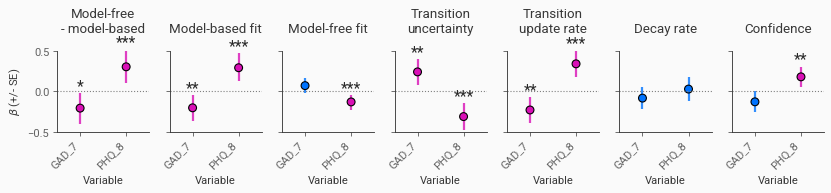

In [5]:
# Create transdiagnostic subdirectory if it does not exist
if not os.path.exists("results/discovery/symptom_models/dep_anx"):
    os.makedirs("results/discovery/symptom_models/dep_anx")

# Create subplots
f, ax = plt.subplots(1, 7, figsize=(10.5, 2.7), sharey=True)

# Common regression formula
formula = "GAD_7 + PHQ_8 + gender + age + motivation"

# Create an empty list to store model objects
anx_dep_models = []

# Create an empty list to store markdown tables
anx_dep_markdown_tables = {}

# Loop through the variables and corresponding titles, running regression and
# plotting for each
for i, (var, title) in enumerate(zip(variables, titles)):
    # If dependent var is confidence, add performance metrics to formula
    if var == "average_confidence":
        model_formula = formula + " + bet_correct"
    else:
        model_formula = formula

    # Get the number of variables we're correcting across This should be 3 (as
    # specified above) if we're looking at one of our Preregistered dependent
    # variables, as the others don't really matter for these analyses
    n_variables_model = (
        n_variables
        if var in ["transition_var", "tau_prob", "MB_MF_WAIC_diff"]
        else 1
    )

    model, _ = run_regression_and_plot(
        qdata,
        var,
        model_formula,
        20000,
        save_fig=False,
        show_summary=False,
        ax=ax[i],
        forest_plot_kwargs={
            "exclude_param_names": [
                "age",
                "gender",
                "motivation",
                "bet_correct",
            ],
            "significance_thresholds": {
                0.001 / n_variables_model: "***",
                0.01 / n_variables_model: "**",
                0.05 / n_variables_model: "*",
            },
            "alpha": 0.05 / n_variables_model,
        },
    )

    anx_dep_models.append(model)  # Store the model object

    # Store the table in markdown form
    anx_dep_markdown_tables[title] = ols_to_markdown_table(
        model, alpha_corr=0.05 / 3, predictor_rename_dict=variable_rename_dict
    )

    # Set title for each subplot
    ax[i].set_title(title, y=1.15)

# Adjust y-axis limits.
ax[0].set_ylim(-0.5, 0.5)

# Remove y label from plots 1-4
for i in range(1, 7):
    ax[i].set_ylabel("")

# Tighten layout
plt.tight_layout()

# Combine results into a dataframe
anx_dep_results = compile_ols_results(anx_dep_models)

# Save the results to a csv file
anx_dep_results.to_csv(
    "results/discovery/symptom_models/anx_dep_results.csv", index=False
)

## Mediation analysis

### Transdiagnostic factors

Here we use mediation analyses to test the hypothesis that the Compulsivity/Intrusive thought -> Transition variance relationship is mediated by the $\tau_p$ (update rate) and $\lambda_p$ (decay rate) parameters.


In [6]:
# Set up covariates
covar = ["AD", "SW", "age", "gender", "motivation"]

# Run the model
mediation_analysis(
    data=qdata,
    x="Compul",
    m=["tau_prob", "decay_prob"],
    y="transition_var",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,tau_prob ~ X,-0.150009,0.048649,2.149497e-03,-0.245571,-0.054447,Yes
1,decay_prob ~ X,-0.132564,0.051069,9.692178e-03,-0.232880,-0.032248,Yes
2,Y ~ tau_prob,-0.831039,0.012385,5.192484e-265,-0.855366,-0.806711,Yes
3,Y ~ decay_prob,-0.356774,0.011827,3.851263e-118,-0.380007,-0.333540,Yes
4,Total,0.161928,0.048939,9.991092e-04,0.065795,0.258061,Yes
5,Direct,-0.010291,0.014163,4.677948e-01,-0.038112,0.017531,No
6,Indirect tau_prob,0.124819,0.041338,4.900000e-03,0.040915,0.203275,Yes
7,Indirect decay_prob,0.047399,0.018963,1.250000e-02,0.010244,0.085147,Yes


This indicates that the link between CIT and transition variance is fully mediated by the update and decay rates of the model. The total effect (X -> Y) is significant, but the direct effect (X -> Y) is not significant when controlling for the mediator (M). The indirect effects (X -> M -> Y) are significant.


Next, we test the hypothesis that the Compulsivity/Intrusive thought -> Model-basedness relationship is mediated by uncertainty about learnt state transitions.

In [7]:
# Set up covariates
covar = ["AD", "SW", "age", "gender", "motivation"]

# Run the model
transdiagnostic_mediation_model = mediation_analysis(
    data=qdata,
    x="Compul",
    m=["transition_var"],
    y="MB_MF_WAIC_diff",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)

# Create a markdown table
transdiagnostic_mediation_table = mediation_analysis_to_markdown_table(
    transdiagnostic_mediation_model, variable_rename_dict=variable_rename_dict
)

Again, this indicates that the relationship is fully mediated by uncertainty about state transitions.

### State anxiety (GAD-7)

We now do the same for state anxiety, as measured by the GAD-7 questionnaire.


In [8]:
# Set up covariates
covar = ["PHQ_8", "AD", "age", "gender", "motivation"]

# Run the model
anx_mediation_model = mediation_analysis(
    data=qdata,
    x="GAD_7",
    m=["tau_prob"],
    y="transition_var",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)

# Create a markdown table
anx_mediation_table = mediation_analysis_to_markdown_table(
    anx_mediation_model, variable_rename_dict=variable_rename_dict
)

### State depression (PHQ-8)

And finally, we do the same for state depression, as measured by the PHQ-8 questionnaire.

In [9]:
# Set up covariates
covar = ["GAD_7", "AD", "age", "gender", "motivation"]

# Run the model
dep_mediation_model = mediation_analysis(
    data=qdata,
    x="PHQ_8",
    m=["tau_prob"],
    y="transition_var",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)

# Create a markdown table
dep_mediation_table = mediation_analysis_to_markdown_table(
    dep_mediation_model, variable_rename_dict=variable_rename_dict
)

## Save markdown tables

We save the tables as markdown files for easy inclusion in the manuscript.

In [10]:
all_tables = {
    "transdiagnostic": transdiagnostic_markdown_tables,
    "transdiagnostic_mediation": {
        "compulsivity and intrusive thought;transition uncertainty;"
        "model-basedness": transdiagnostic_mediation_table
    },
    "anx_dep": anx_dep_markdown_tables,
    "anx_mediation": {
        "anxiety;transition uncertainty;model-basedness": transdiagnostic_mediation_table,
        "depression;transition uncertainty;model-basedness": transdiagnostic_mediation_table,
    },
}

caption_and_save_markdown_tables(
    all_tables, "discovery", "paper/supplementary_tables.md", append=True
)

Appending to existing file: paper/supplementary_tables.md
Conversion to PDF completed successfully.
Conversion to docx completed successfully.
